<a href="https://colab.research.google.com/github/kowsiknd/gan-cgan-scratch-tensorflow/blob/main/GAN_and_cGAN_Scratch_Tensorflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# GAN and cGAN Scratch - Tensorflow
---



In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'2.6.0'

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.34.244.122:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.34.244.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.34.244.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Download and Import datasets

In [4]:
fashion_dataset = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_dataset.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [6]:
def plot_image_grid(data, x=10, y=10):
  for i in range(x*y):
    # define subplot
    plt.subplot(x, y, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(data[i], cmap='gray_r')
  plt.show()

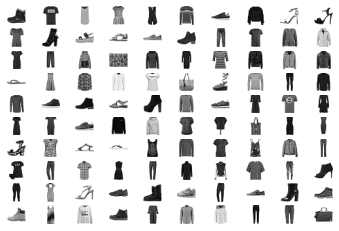

In [7]:
plot_image_grid(x_train, x=10, y=10)

# Unconditional GAN

## Discriminator Model

In [8]:
def define_discriminator_model(input_shape=(28, 28, 1), learning_rate=0.0002, beta_1=0.5):
  model = keras.Sequential([
    layers.InputLayer(input_shape=input_shape),   
    # Down Sample                    
    layers.Conv2D(128, 3, strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    # Down Sample
    layers.Conv2D(128, 3, strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    # Classifier
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")
  ])

  # Compile
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1) ,
      loss=keras.losses.binary_crossentropy,
      metrics=["accuracy"]
  )

  return model

In [9]:
test_discriminator_model = define_discriminator_model()
test_discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

## Generator Model

In [10]:
def define_generator_model(latent_dim, n_nodes=(128*7*7)):
  """
    n_nodes = foundation for 7x7
  """
  model = keras.Sequential([
    # Foundation for image input
    layers.Dense(n_nodes, input_dim=latent_dim),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((7, 7, 128)),
    # Upsample to 14x14
    layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    # Upsample to 28x28
    layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    # generate
    layers.Conv2D(1, 7, activation="tanh", padding="same")
  ])

  return model

In [11]:
test_generator_model = define_generator_model(100)
test_generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

## GAN Model

In [12]:
def define_gan_model(generator, discriminator, learning_rate=0.0002, beta_1=0.5):
  # No training during generator training
  discriminator.trainable = False

  # Connection
  model = keras.Sequential([
    generator,
    discriminator
  ])

  # Compile
  model.compile(
      loss=keras.losses.binary_crossentropy,
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
      metrics=["accuracy"]
  )

  return model

In [13]:
test_gan_model = define_gan_model(test_generator_model, test_discriminator_model)
test_gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 155137    
Total params: 1,319,426
Trainable params: 1,164,289
Non-trainable params: 155,137
_________________________________________________________________


## Dataset generation

### Real Samples

In [14]:
def load_real_sample():
  (Xtrain, _), (_, _) = fashion_dataset.load_data()
  X = np.expand_dims(Xtrain, axis=-1)
  X = X.astype('float32')
  X = (X-127.5) / 127.5
  return X

In [15]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return X, y

(10, 28, 28, 1)


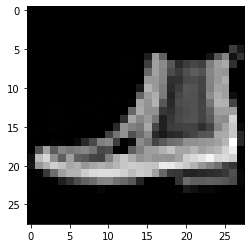

In [16]:
test_real_gen = generate_real_samples(load_real_sample(), 10)
print(test_real_gen[0].shape)
# print(test_real_gen[0][0])
plt.imshow(test_real_gen[0][0].reshape(28, 28), cmap="gray")
plt.show()

### Latent Samples


In [17]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

#### Fake Samples

In [18]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return X, y

(10, 28, 28, 1)


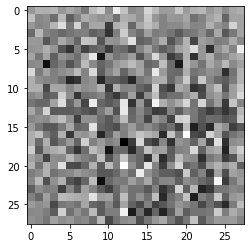

In [19]:
test_fake_gen = generate_fake_samples(test_generator_model, 100, 10)
print(test_fake_gen[0].shape)
# print(test_fake_gen[0][0])
plt.imshow(test_fake_gen[0][0].reshape(28, 28), cmap="gray")
plt.show()

## Training Models

In [20]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=100, n_batches=128):
  batch_per_epoch = int (dataset.shape[0] / n_batches)
  half_batch = int (n_batches / 2)
  # manual epoch
  for i in range(n_epochs):
    # enumerate over batches
    for j in range(batch_per_epoch):
      # Train discriminator over real images
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)

      # Train discriminator over fake images
      X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)

      # generate latent points and trian gan
      X_latent = generate_latent_points(latent_dim, n_batches)
      y_latent = np.ones((n_batches, 1))

      gan_loss, _ = gan.train_on_batch(X_latent, y_latent)

      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, batch_per_epoch, d_loss_real, d_loss_fake, gan_loss))
  # save the generator model
  generator.save('generator.h5')

### Execution

In [21]:
latent_dim = 100
discriminator = define_discriminator_model()
generator = define_generator_model(latent_dim)
gan = define_gan_model(generator=generator, discriminator=discriminator)

dataset = load_real_sample()

In [22]:
# train(generator, discriminator, gan, dataset, latent_dim, n_epochs=10)

In [23]:
generator.save('gan_generator.h5')

In [24]:
discriminator.save('gan_discriminator.h5')


In this case, the discriminator and generator loss both sit around values of about 0.6 to 0.7 over the course of training

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 128)      

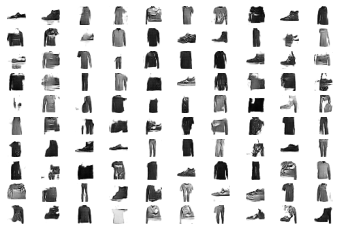

In [25]:
# from keras.models import load_model
# from numpy.random import randn
# from matplotlib import pyplot
 
# # generate points in latent space as input for the generator
def generate_latent_points_prediction(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# # create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
 
# load model
model = keras.models.load_model("/content/drive/MyDrive/GAN Fashion/gan_generator.h5")
print(model.summary())
# generate images
latent_points = generate_latent_points_prediction(100, 100)
# generate images
X = model.predict(latent_points)
print(X.shape)
# plot the result
show_plot(X, 10)

# Conditional GAN

In [26]:
def c_define_discriminator(input_shape=(28, 28, 1), n_classes=10, learning_rate=0.0002, beta_1=0.5):
  # Input Label
  in_label = layers.Input(shape=(1,))
  # Embedding for categorical input
  li = layers.Embedding(n_classes, 50)(in_label)
  n_nodes = input_shape[0] * input_shape[1]
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((input_shape[0], input_shape[1], 1))(li)

  # Input Image
  in_image = layers.Input(shape=input_shape)

  # Concatenate labels and images
  merge = layers.Concatenate()([in_image, li])

  # DownSample
  x = layers.Conv2D(128, 3, strides=(2, 2), padding="same")(merge)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Conv2D(128, 3, strides=(2, 2), padding="same")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)
  out_layer = layers.Dense(1, activation="sigmoid")(x)

  # Define Model
  model = keras.Model([in_image, in_label], out_layer)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
      loss=keras.losses.binary_crossentropy,
      metrics=["accuracy"]
  )

  return model

In [27]:
test_c_discriminator_model = c_define_discriminator()
print(test_c_discriminator_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

In [28]:
def c_define_generator(latent_dim, n_classes=10):
  # Input Label
  in_label = layers.Input(shape=(1,))
  # Embedding for categorical input
  li = layers.Embedding(n_classes, 50)(in_label)
  n_nodes = 7 * 7
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((7, 7, 1))(li)

  # Input generator latent image
  in_latent = layers.Input(shape=(latent_dim, ))
  n_nodes = 128 * 7 * 7
  x = layers.Dense(n_nodes)(in_latent)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((7, 7, 128))(x)

  # Merge layers
  merge = layers.Concatenate()([x, li])

  # Upsampling
  x = layers.Conv2DTranspose(128, 4, strides=(2, 2), padding="same")(merge)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Conv2DTranspose(128, 4, strides=(2, 2), padding="same")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  out_layer = layers.Conv2D(1, 7, activation="tanh", padding="same")(x)

  model = keras.Model([in_latent, in_label], out_layer)
  return model

In [29]:
test_c_generator_model = c_define_generator(100)
print(test_c_generator_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 6272)         633472      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_5[0][0]                    
____________________________________________________________________________________________

In [30]:
def c_define_cgan_model(generator, discriminator, learning_rate=0.0002, beta_1=0.5):
  discriminator.trainable = False

  # get noise and label inputs from generator model
  get_noise, get_label = generator.input
  get_output = generator.output

  # connect image output and label input from generator as inputs to discriminator
  gan_output = discriminator([get_output, get_label])

  model = keras.Model([get_noise, get_label], gan_output)
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
      loss=keras.losses.binary_crossentropy,
      metrics=["accuracy"]
  )

  return model


In [31]:
test_c_gan_model = c_define_cgan_model(test_c_generator_model, test_c_discriminator_model)
print(test_c_gan_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 6272)         633472      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_5[0][0]                    
____________________________________________________________________________________________

In [32]:
from keras.utils.vis_utils import plot_model

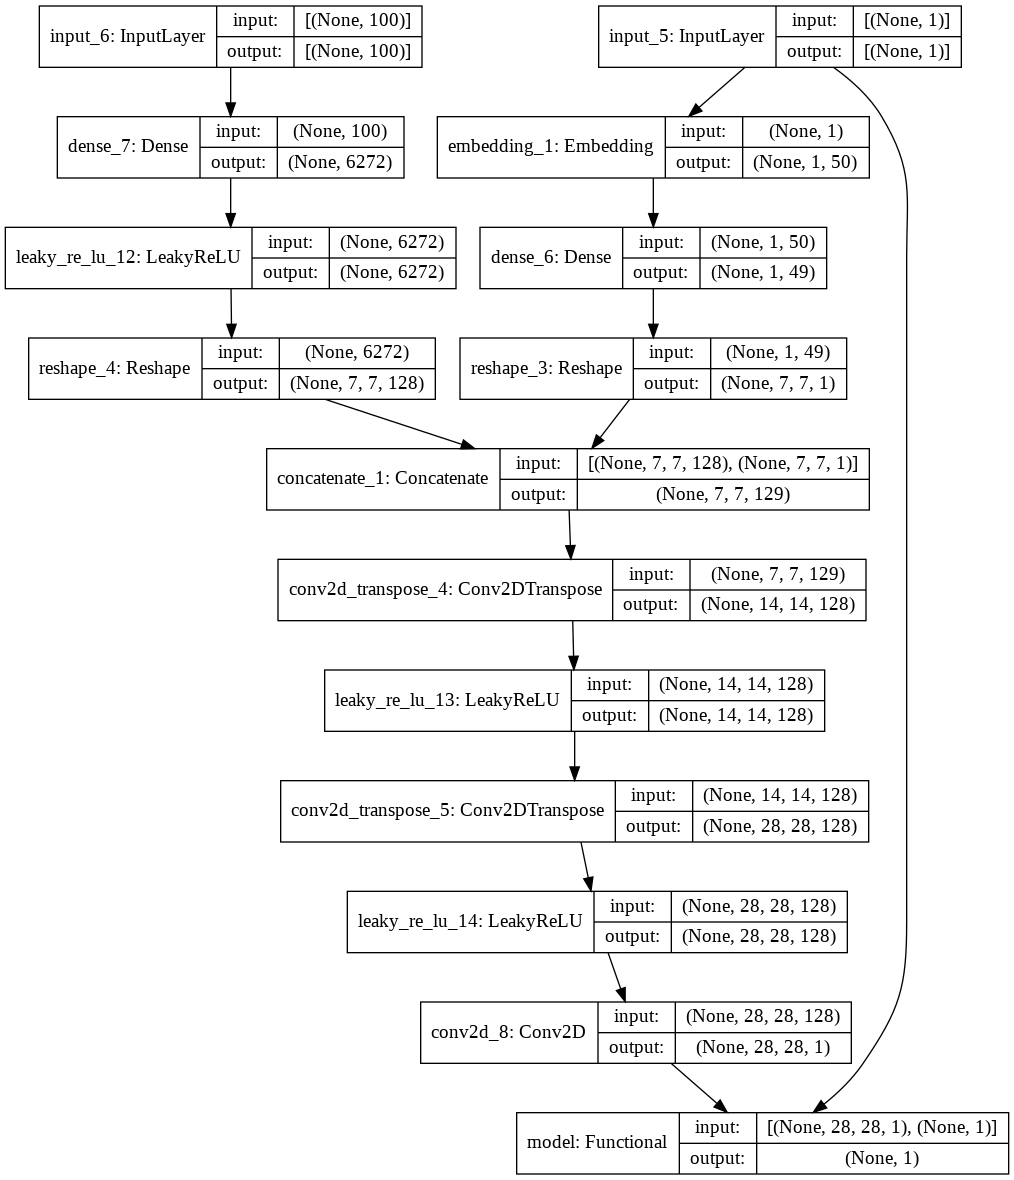

In [33]:
plot_model(model=test_c_gan_model, show_shapes=True, show_layer_names=True)

In [34]:
(x_train, y_train), (_, _) = fashion_dataset.load_data()
print(x_train.shape)
np.expand_dims(x_train, axis=-1).shape

(60000, 28, 28)


(60000, 28, 28, 1)

In [35]:
def c_load_real_samples():
  (x_train, y_train), (_, _) = fashion_dataset.load_data()
  x = np.expand_dims(x_train, axis=-1)
  x = x.astype("float32")
  x = (x - 127.5) / 127.5
  return [x, y_train]

In [36]:
def c_generate_real_samples(datasets, n_samples):
  images, labels = datasets
  ix = np.random.randint(0, images.shape[0], n_samples)
  x, labels = images[ix], labels[ix]
  y = np.ones((n_samples, 1))
  return [x, labels], y

In [37]:
def c_generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def c_generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = c_generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [38]:
def c_train(generator, discriminator, gan, dataset, latent_dim, n_epochs=100, n_batch=128):
  batch_per_epoch = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      [X_real, labels_real], y_real = c_generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = c_generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = c_generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss, _ = gan.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
        (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
      # save the generator model
  generator.save('cgan_generator.h5')

In [39]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = c_define_discriminator()
# create the generator
g_model = c_define_generator(latent_dim=latent_dim)
# create the gan
gan_model = c_define_cgan_model(g_model, d_model)
# load image data
dataset = c_load_real_samples()
# train model
c_train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128)

>1, 1/468, d1=0.654, d2=0.697 g=0.690
>1, 2/468, d1=0.579, d2=0.701 g=0.687
>1, 3/468, d1=0.524, d2=0.706 g=0.683
>1, 4/468, d1=0.459, d2=0.711 g=0.679
>1, 5/468, d1=0.403, d2=0.714 g=0.682
>1, 6/468, d1=0.326, d2=0.707 g=0.691
>1, 7/468, d1=0.284, d2=0.694 g=0.708
>1, 8/468, d1=0.238, d2=0.684 g=0.716
>1, 9/468, d1=0.235, d2=0.693 g=0.706
>1, 10/468, d1=0.167, d2=0.729 g=0.669
>1, 11/468, d1=0.141, d2=0.798 g=0.614
>1, 12/468, d1=0.117, d2=0.900 g=0.553
>1, 13/468, d1=0.135, d2=1.006 g=0.501
>1, 14/468, d1=0.146, d2=1.105 g=0.479
>1, 15/468, d1=0.156, d2=1.088 g=0.505
>1, 16/468, d1=0.186, d2=0.989 g=0.605
>1, 17/468, d1=0.219, d2=0.785 g=0.761
>1, 18/468, d1=0.279, d2=0.610 g=0.960
>1, 19/468, d1=0.296, d2=0.466 g=1.181
>1, 20/468, d1=0.299, d2=0.358 g=1.359
>1, 21/468, d1=0.309, d2=0.308 g=1.485
>1, 22/468, d1=0.359, d2=0.319 g=1.426
>1, 23/468, d1=0.304, d2=0.358 g=1.299
>1, 24/468, d1=0.288, d2=0.417 g=1.122
>1, 25/468, d1=0.252, d2=0.501 g=0.956
>1, 26/468, d1=0.211, d2=0.576 g=0

In [40]:
d_model.save("c_gan_discriminator.h5")
g_model.save("c_gan_generator.h5")
gan_model.save("c_gan_full.h5")